# FoodSG-10

### Import Required Libraries

In [21]:
# import torch
import torch
from torch import nn
from torch.utils.data import DataLoader

# import torchvision and image related
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor # convert image to tensor so it can be used in the model
from torchvision.datasets import ImageFolder
from PIL import Image

# import metrics related
import torchmetrics
import mlxtend
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# import request-getter
import requests
import os
import zipfile
from pathlib import Path

# Other libraries
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
from tqdm.auto import tqdm
from math import ceil
import random
from sklearn.model_selection import train_test_split
import shutil
import subprocess



### Organise Data into Test and Train Data

In [22]:
shutil.rmtree("data", ignore_errors=True)
old_dir = Path("foodsg-10")
save_dir = Path("data")
os.makedirs(save_dir, exist_ok=True)
class_names = next(os.walk(old_dir))[1] # Get the immediate subdirectories
train_dir = save_dir / "train"
test_dir = save_dir / "test"
for class_name in class_names:
    old_subdir = old_dir / class_name
    train_path_list, test_path_list = train_test_split(list(old_subdir.glob("*.jpg")), test_size=0.2)
    os.makedirs(train_dir / class_name, exist_ok=True)
    os.makedirs(test_dir / class_name, exist_ok=True)
    for image_path in train_path_list:
        shutil.copy2(image_path, train_dir / class_name)
    for image_path in test_path_list:
        shutil.copy2(image_path, test_dir / class_name)

### Define Transform Function for X Data, and set up Dataset / DataLoader

In [23]:
data_transform = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  # Resize to 64 x 64 for faster processing, without losing too much detail
  transforms.RandomHorizontalFlip(p=0.5),
  # Flip horizontally by random to increase the diversity of the dataset
  # More Data Augmentation
  transforms.RandomRotation(15), # Random Rotation Added
  transforms.RandomCrop(size=(64, 64), padding=4),  # Random cropping with padding
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust colors
  transforms.RandomGrayscale(p=0.1),  # Occasionally make the image grayscale
  transforms.ToTensor()
  # Convert it to a tensor
])

In [24]:
train_data = ImageFolder(root=train_dir,
                         transform=data_transform,
                         target_transform=None)
test_data = ImageFolder(root=test_dir,
                        transform=data_transform,
                        target_transform=None)

train_data.classes, train_data[0], train_data[0][0].shape, len(train_data)
# train_data

(['Laksa',
  'Mee siam',
  'Prawn Noodle',
  'bak kut teh',
  'chai tow kuay',
  'cheng tng',
  'mixed vegetables',
  'nasi lemak',
  'sliced fish soup',
  'yong tau foo'],
 (tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
           [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
           [0.0157, 0.0157, 0.0157,  ..., 0.3647, 0.0157, 0.0157],
           ...,
           [0.0157, 0.0157, 0.0157,  ..., 0.3412, 0.3412, 0.3333],
           [0.0157, 0.0157, 0.0157,  ..., 0.3412, 0.3412, 0.3333],
           [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157]],
  
          [[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
           [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
           [0.0157, 0.0157, 0.0157,  ..., 0.0588, 0.0157, 0.0157],
           ...,
           [0.0157, 0.0157, 0.0157,  ..., 0.0549, 0.0588, 0.0471],
           [0.0157, 0.0157, 0.0157,  ..., 0.0549, 0.0588, 0.0471],
           [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.01

In [25]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


### Define the model

In [26]:
class FoodModelV0(nn.Module):
  def __init__(self,
               input_shape,
               output_shape,
               sample_X,
               hidden_units=10):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=1,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=1,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout added
        nn.MaxPool2d(kernel_size=2)
    )

    r = torch.randn(sample_X.shape)
    r = self.conv_block2(self.conv_block1(r))
    # Derive the input_features needed for the Linear layer
    in_feat = r.shape[1] * r.shape[2] * r.shape[3]

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_feat,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block2(self.conv_block1(x)))

In [27]:
class FoodModelV1(nn.Module):
  def __init__(self,
               input_shape,
               output_shape,
               sample_X,
               hidden_units=32):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Batch normalization added
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=1,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Batch normalization added
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Batch normalization added
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=1,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Batch normalization added
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Batch normalization added
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=1,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Batch normalization added
        nn.ReLU(),
        nn.Dropout(p=0.5), # Dropout added
        nn.MaxPool2d(kernel_size=2)
    )

    r = torch.randn(sample_X.shape)
    r = self.conv_block3(self.conv_block2(self.conv_block1(r)))
    # Derive the input_features needed for the Linear layer
    in_feat = r.shape[1] * r.shape[2] * r.shape[3]

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_feat,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block3(self.conv_block2(self.conv_block1(x))))

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_X, train_y = next(iter(train_dataloader))
model_0 = FoodModelV1(input_shape=train_X.shape[1], # Number of Colour Channels
                      output_shape=len(train_data.classes), # Number of classes
                      sample_X=train_X,
                      hidden_units=32).to(device)

### Set up Loss, Optimiser and Evaluation Functions

In [29]:
loss_fn = nn.CrossEntropyLoss()
optim_fn = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001,
                            weight_decay=1e-5) # Weight decay added for L2
sched_fn = torch.optim.lr_scheduler.StepLR(optim_fn, step_size=10, gamma=0.1)
def acc_fn(y_true, y_pred):
  return torch.eq(y_true, y_pred).sum().item() / len(y_true)

def print_duration(start, end, device):
  print(f"Duration {end - start} secs on {device}")

### Preliminary Set up

In [30]:
epochs = 50  # Stop early
test_freq = 5

epoch_count = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []


In [31]:
def train_step(model, dataloader, device, loss_fn, acc_fn):
  model.train()
  train_loss, train_acc = 0, 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_labels = y_logits.softmax(dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y)
    train_loss += loss
    train_acc += acc_fn(y, y_labels)

    optim_fn.zero_grad()
    loss.backward()
    optim_fn.step()
  
  # Step the scheduler
  sched_fn.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return (model, train_loss, train_acc)

def test_step(model, dataloader, device, loss_fn, acc_fn):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      test_labels = test_logits.softmax(dim=1).argmax(dim=1)
      test_loss += loss_fn(test_logits, y)
      test_acc += acc_fn(y, test_labels)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return (test_loss, test_acc)


### Train model

In [32]:
start = timer()
for epoch in tqdm(range(epochs)):
  model_0, train_loss, train_acc = train_step(model_0, train_dataloader, device, loss_fn, acc_fn)

  if epoch % test_freq == 0:
    with torch.inference_mode():
      epoch_count.append(epoch)
      train_losses.append(train_loss.cpu().numpy())
      train_accs.append(train_acc)
      test_loss, test_acc = test_step(model_0, test_dataloader, device, loss_fn, acc_fn)
      test_losses.append(test_loss.cpu().numpy())
      test_accs.append(test_acc)

end = timer()
print_duration(start, end, device)

100%|██████████| 50/50 [54:48<00:00, 65.78s/it]  

Duration 3288.953303999966 secs on cpu


### Plot Results

In [33]:
# Define the print_and_plot_loss code
def print_and_plot_loss(test_freq, epoch_count, loss_values, acc_values,
                        test_loss_values, test_acc_values):
  for i in range(len(epoch_count)):
    print(f"Epoch {i * test_freq}: Loss = {loss_values[i]} Acc = {acc_values[i]} Test Loss = {test_loss_values[i]} Test Acc = {test_acc_values[i]}")
  figure, axis = plt.subplots(1, 2, figsize=(14, 6))

  axis[0].plot(epoch_count, loss_values, label="Training Loss")
  axis[1].plot(epoch_count, acc_values, label="Training Accuracy")
  axis[0].plot(epoch_count, test_loss_values, label="Testing Loss")
  axis[1].plot(epoch_count, test_acc_values, label="Testing Accuracy")

  # Label the plot
  axis[0].set_title("Training and Testing Loss Curves");
  plt.subplot(1, 2, 1)
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend();
  axis[1].set_title("Training and Testing Accuracy Curves")
  plt.subplot(1, 2, 2)
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.tight_layout()
  plt.legend()

# Evaluate the model using a run of the test step
def eval_model(model, dataloader, device, loss_fn, acc_fn):
  (test_loss, test_acc) = test_step(model, dataloader, device, loss_fn, acc_fn)
  print(f"Model Performance\nTest Loss: {test_loss:.3f}\nTest Accuracy: {test_acc * 100:.3f}%")


Epoch 0: Loss = 2.169457197189331 Acc = 0.24717782851344494 Test Loss = 2.035196542739868 Test Acc = 0.2772727272727273
Epoch 5: Loss = 1.5852444171905518 Acc = 0.4500095129375951 Test Loss = 1.7876571416854858 Test Acc = 0.39737762237762236
Epoch 10: Loss = 1.3352888822555542 Acc = 0.5308800524268561 Test Loss = 1.446769118309021 Test Acc = 0.534222027972028
Epoch 15: Loss = 1.2688288688659668 Acc = 0.5547892355826146 Test Loss = 1.3964303731918335 Test Acc = 0.5513986013986014
Epoch 20: Loss = 1.2359213829040527 Acc = 0.5705648570945375 Test Loss = 1.354063868522644 Test Acc = 0.5580419580419581
Epoch 25: Loss = 1.23958420753479 Acc = 0.5716271351259936 Test Loss = 1.342882513999939 Test Acc = 0.5591783216783217
Epoch 30: Loss = 1.212182879447937 Acc = 0.5799298156604092 Test Loss = 1.332779884338379 Test Acc = 0.5692744755244755
Epoch 35: Loss = 1.212754487991333 Acc = 0.5787618383223406 Test Loss = 1.3521260023117065 Test Acc = 0.5428758741258741
Epoch 40: Loss = 1.210952877998352 

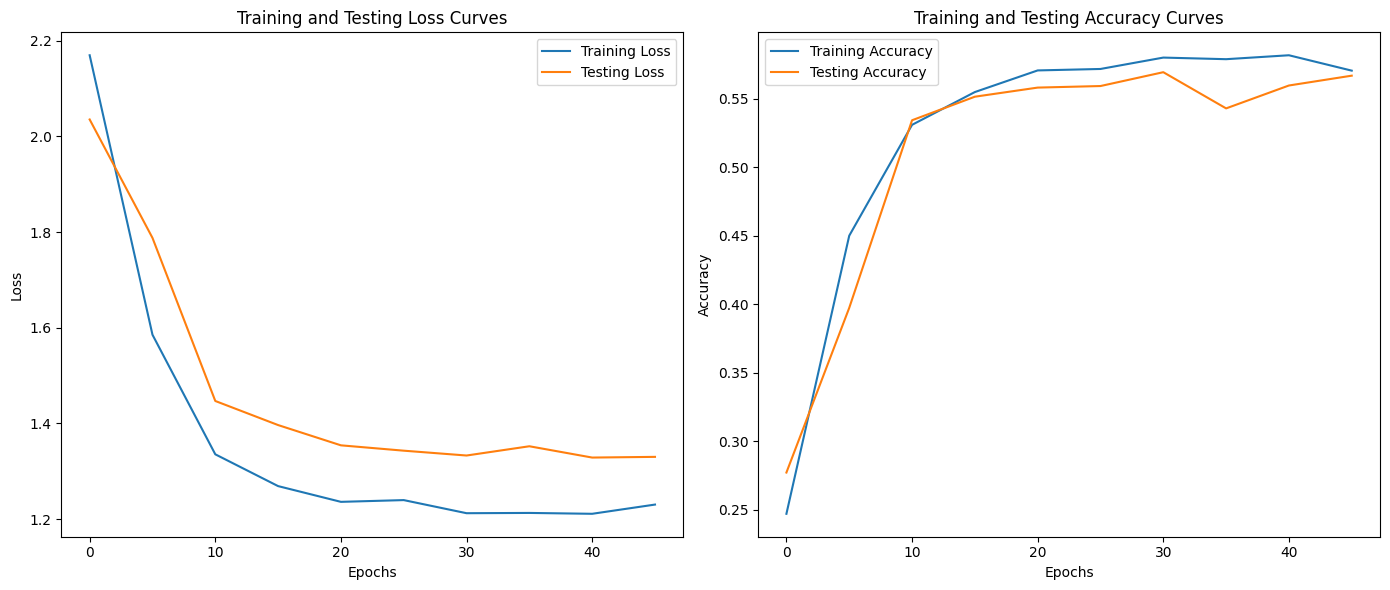

In [34]:
print_and_plot_loss(test_freq, epoch_count, train_losses, train_accs,
                    test_losses, test_accs)

In [35]:
eval_model(model_0, test_dataloader, device, loss_fn, acc_fn)

Model Performance
Test Loss: 1.346
Test Accuracy: 55.721%


## Improving the model

https://medium.com/@datascienceeurope/do-you-know-overfitting-and-underfitting-f27f87ac2f37

Compare the loss functions of train against test, to derive whether the performance is one of the below:

* **Underfitting**: Training Loss and Testing Loss are HIGH.
  * Model has not learned the Training Data well enough.


* **Overfitting**: Training Loss is VERY LOW, but Testing Loss is MID-HIGH.
  * Model is over-fitted to the Training Data, such that it performs poorly in the Testing Data.

* **Just Right**: Training loss is slightly LOWER than Testing Loss, but both are low.
  * Model is fitted just right to the training data.

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

There are other types of weird loss curves that can be observed.

Experimentation Records:

Attempt 1: The initial loss curve obtained was Oscillating.

Change: decrease learning rate from 0.01 to 0.001.

Attempt 2: Observed much lesser oscillating, though some oscillating remained, and a clear trend of testing above training loss.

Change: Increase hidden units to 20. Decreased to 50 epochs for faster testing.

Attempt 3: Observed even clearer over fitting. Improving training loss but testing loss increasing.

Change: Increased to 100 epochs

Attempt 4: Clearer overfitting observed, accuracy around 40-50%. (12JanModelV0.pth)

Change: Identified overfitting, and took following steps to improve:
- Added Dropout in Conv_Block 2
- Data Augmentation: Added random rotation
- L2 regularisation: Added weight_decay to Adam optimiser
- Early stopping: Decreased number of epochs to 50

Attempt 5: Overfitting clearly improved, though there is still a significant gap between train and test loss.

Change: Further improvements made to overfitting:
- Data Augmentation: Added RandomCrop, ColorJitter, RandomGrayscale
- Add Conv Block, and increase to 32 hidden units
- Use stepLR scheduler to schedule the learning rate of the optimiser
- Add batch normalisation layers to stabilise the layers

### Where does the model trip?

In [36]:
def plot_data(model, dataloader, device, classes, rows=5, cols=5, plotRights=True):
  count = 0
  model.eval()
  figure, axis = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      # Obtain predictions
      test_logits = model(X)
      test_labels = test_logits.softmax(dim=1).argmax(dim=1)
      for i in range(X.shape[0]):
        if count >= rows * cols:
          plt.show()
          return
        image = X[i].cpu().numpy()
        imageHWC = image.transpose(1, 2, 0)
        pred_label, act_label = int(test_labels[i]), int(y[i].cpu().numpy())
        if plotRights and pred_label == act_label:
          axis[int(count/cols), count%cols].imshow(imageHWC, cmap="gray")
          axis[int(count/cols), count%cols].set_title(f"Pred: {classes[pred_label]} Act: {classes[act_label]}", c="g")
          count += 1
        elif not plotRights and pred_label != act_label:
          axis[int(count/cols), count%cols].imshow(imageHWC, cmap="gray")
          axis[int(count/cols), count%cols].set_title(f"Pred: {classes[pred_label]} Act: {classes[act_label]}", c="r")
          count += 1

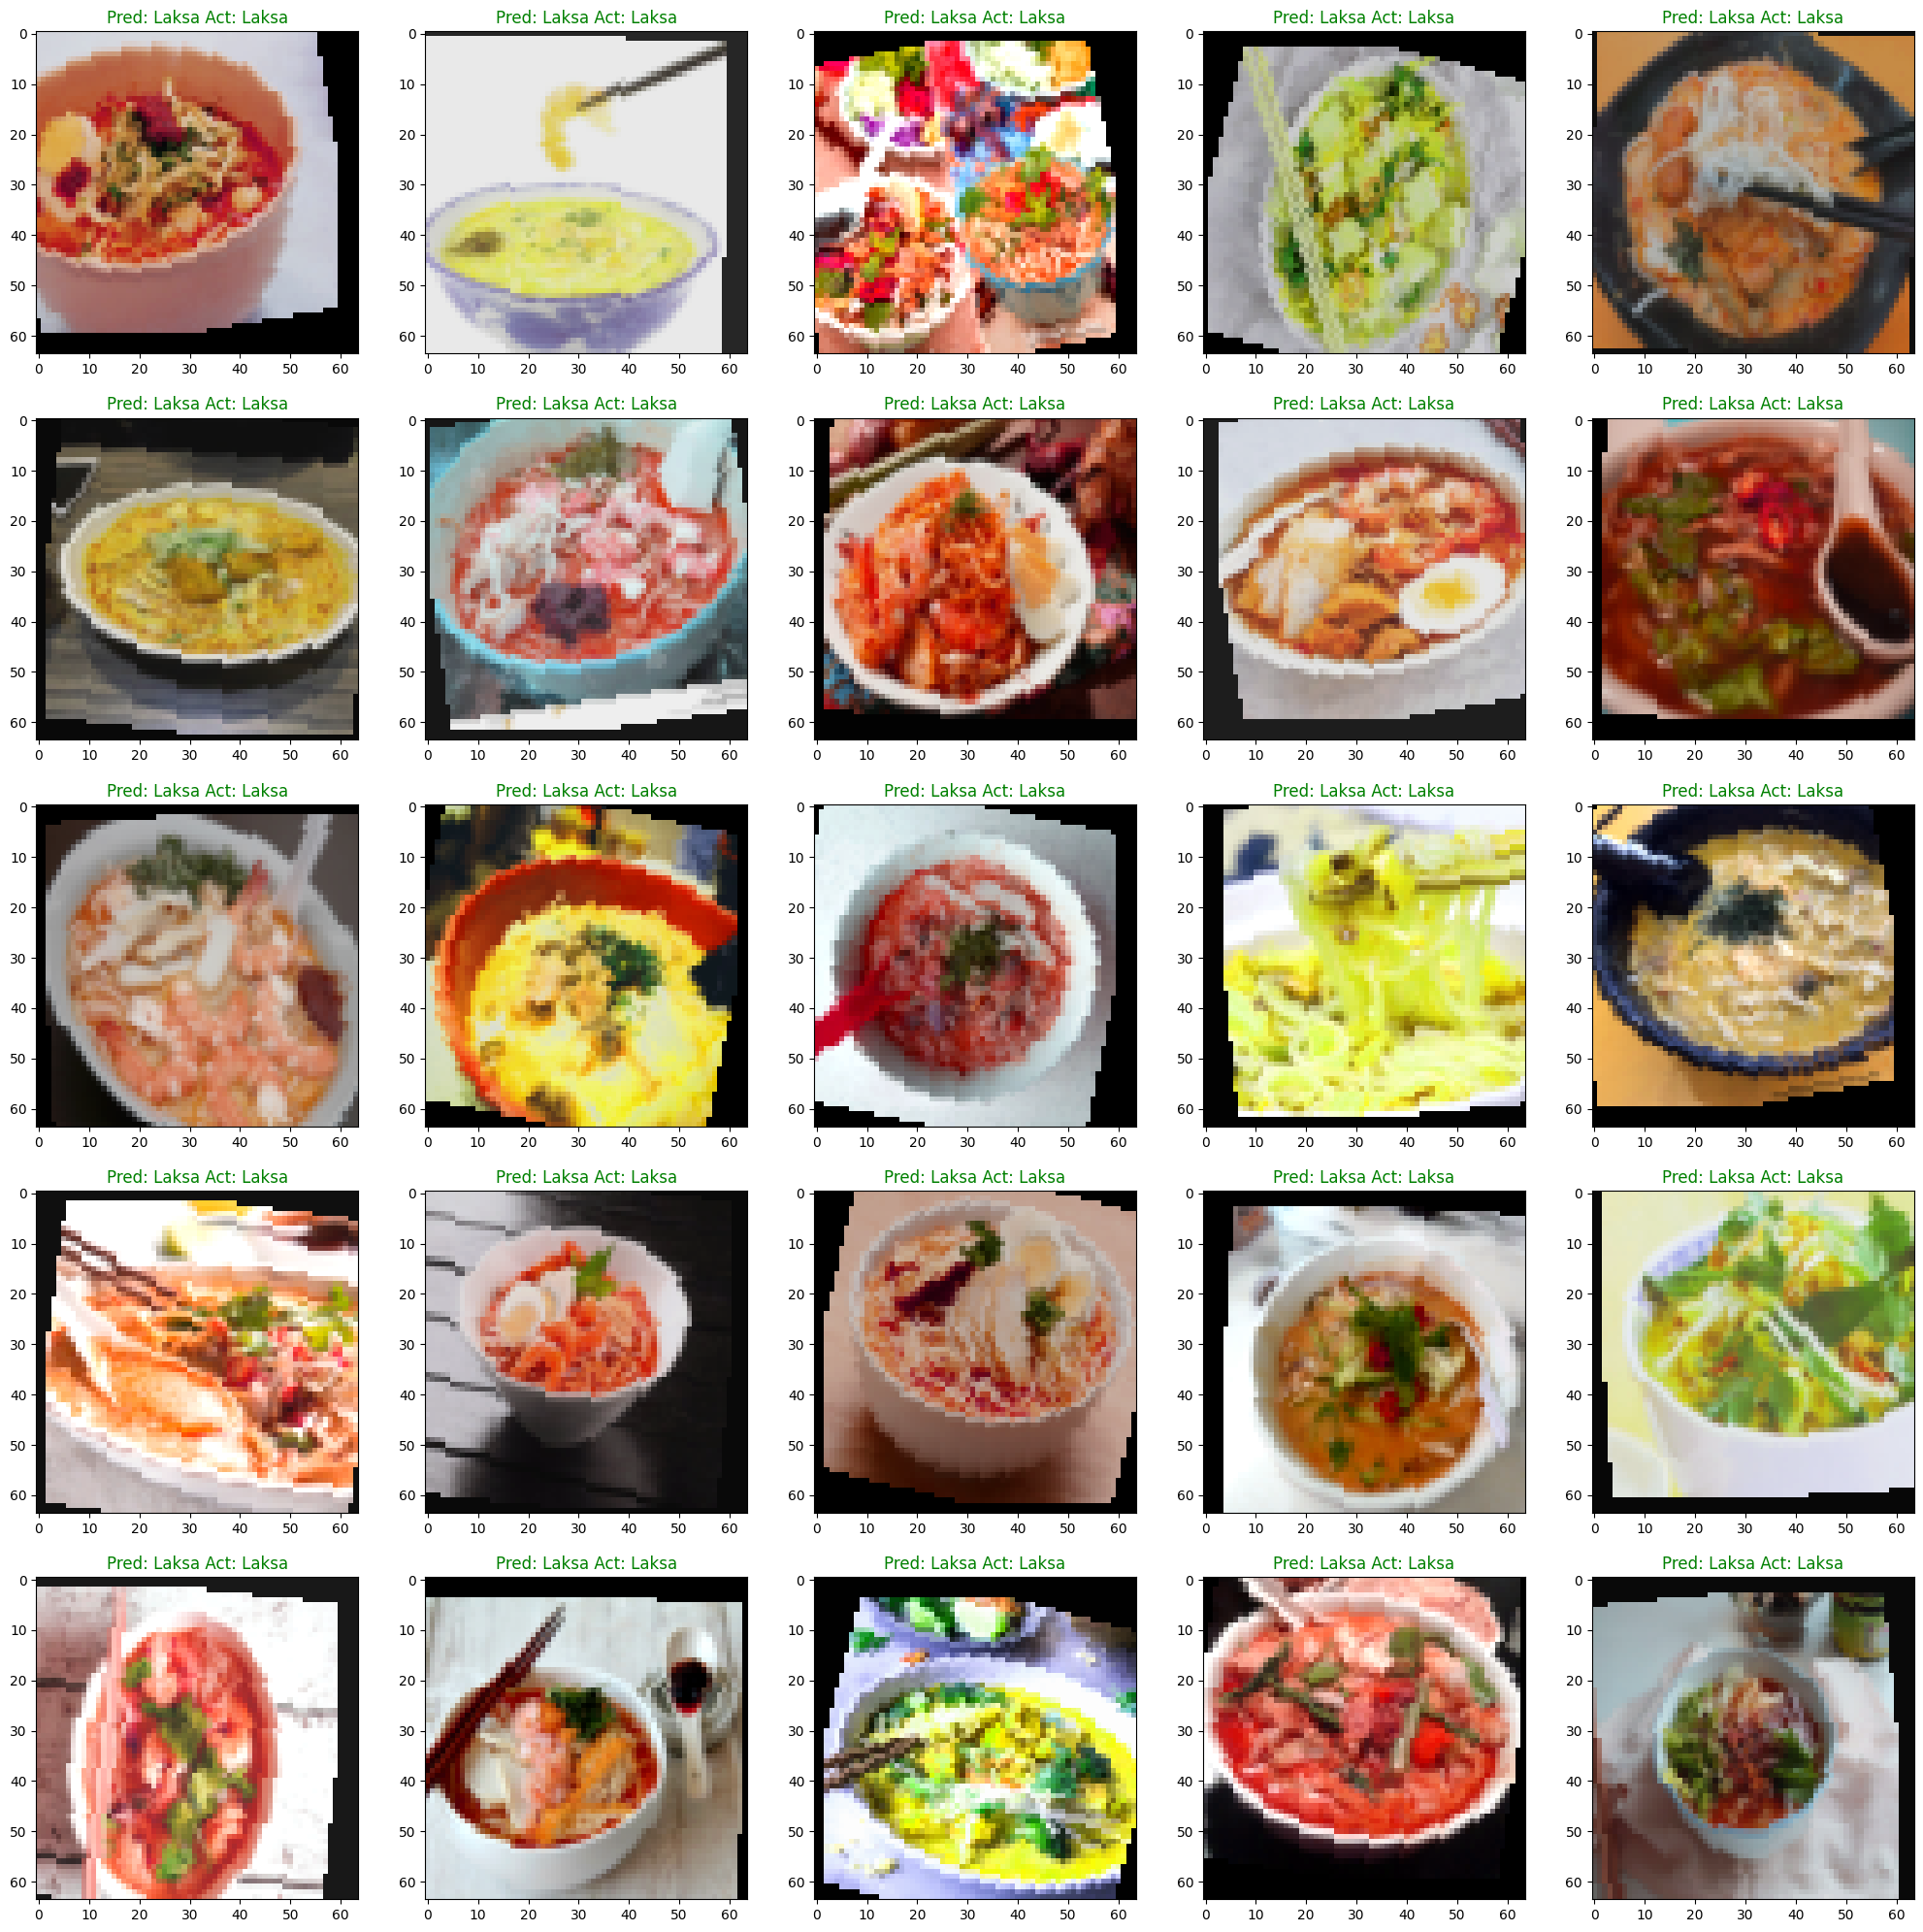

In [37]:
plot_data(model_0, test_dataloader, device, train_data.classes)

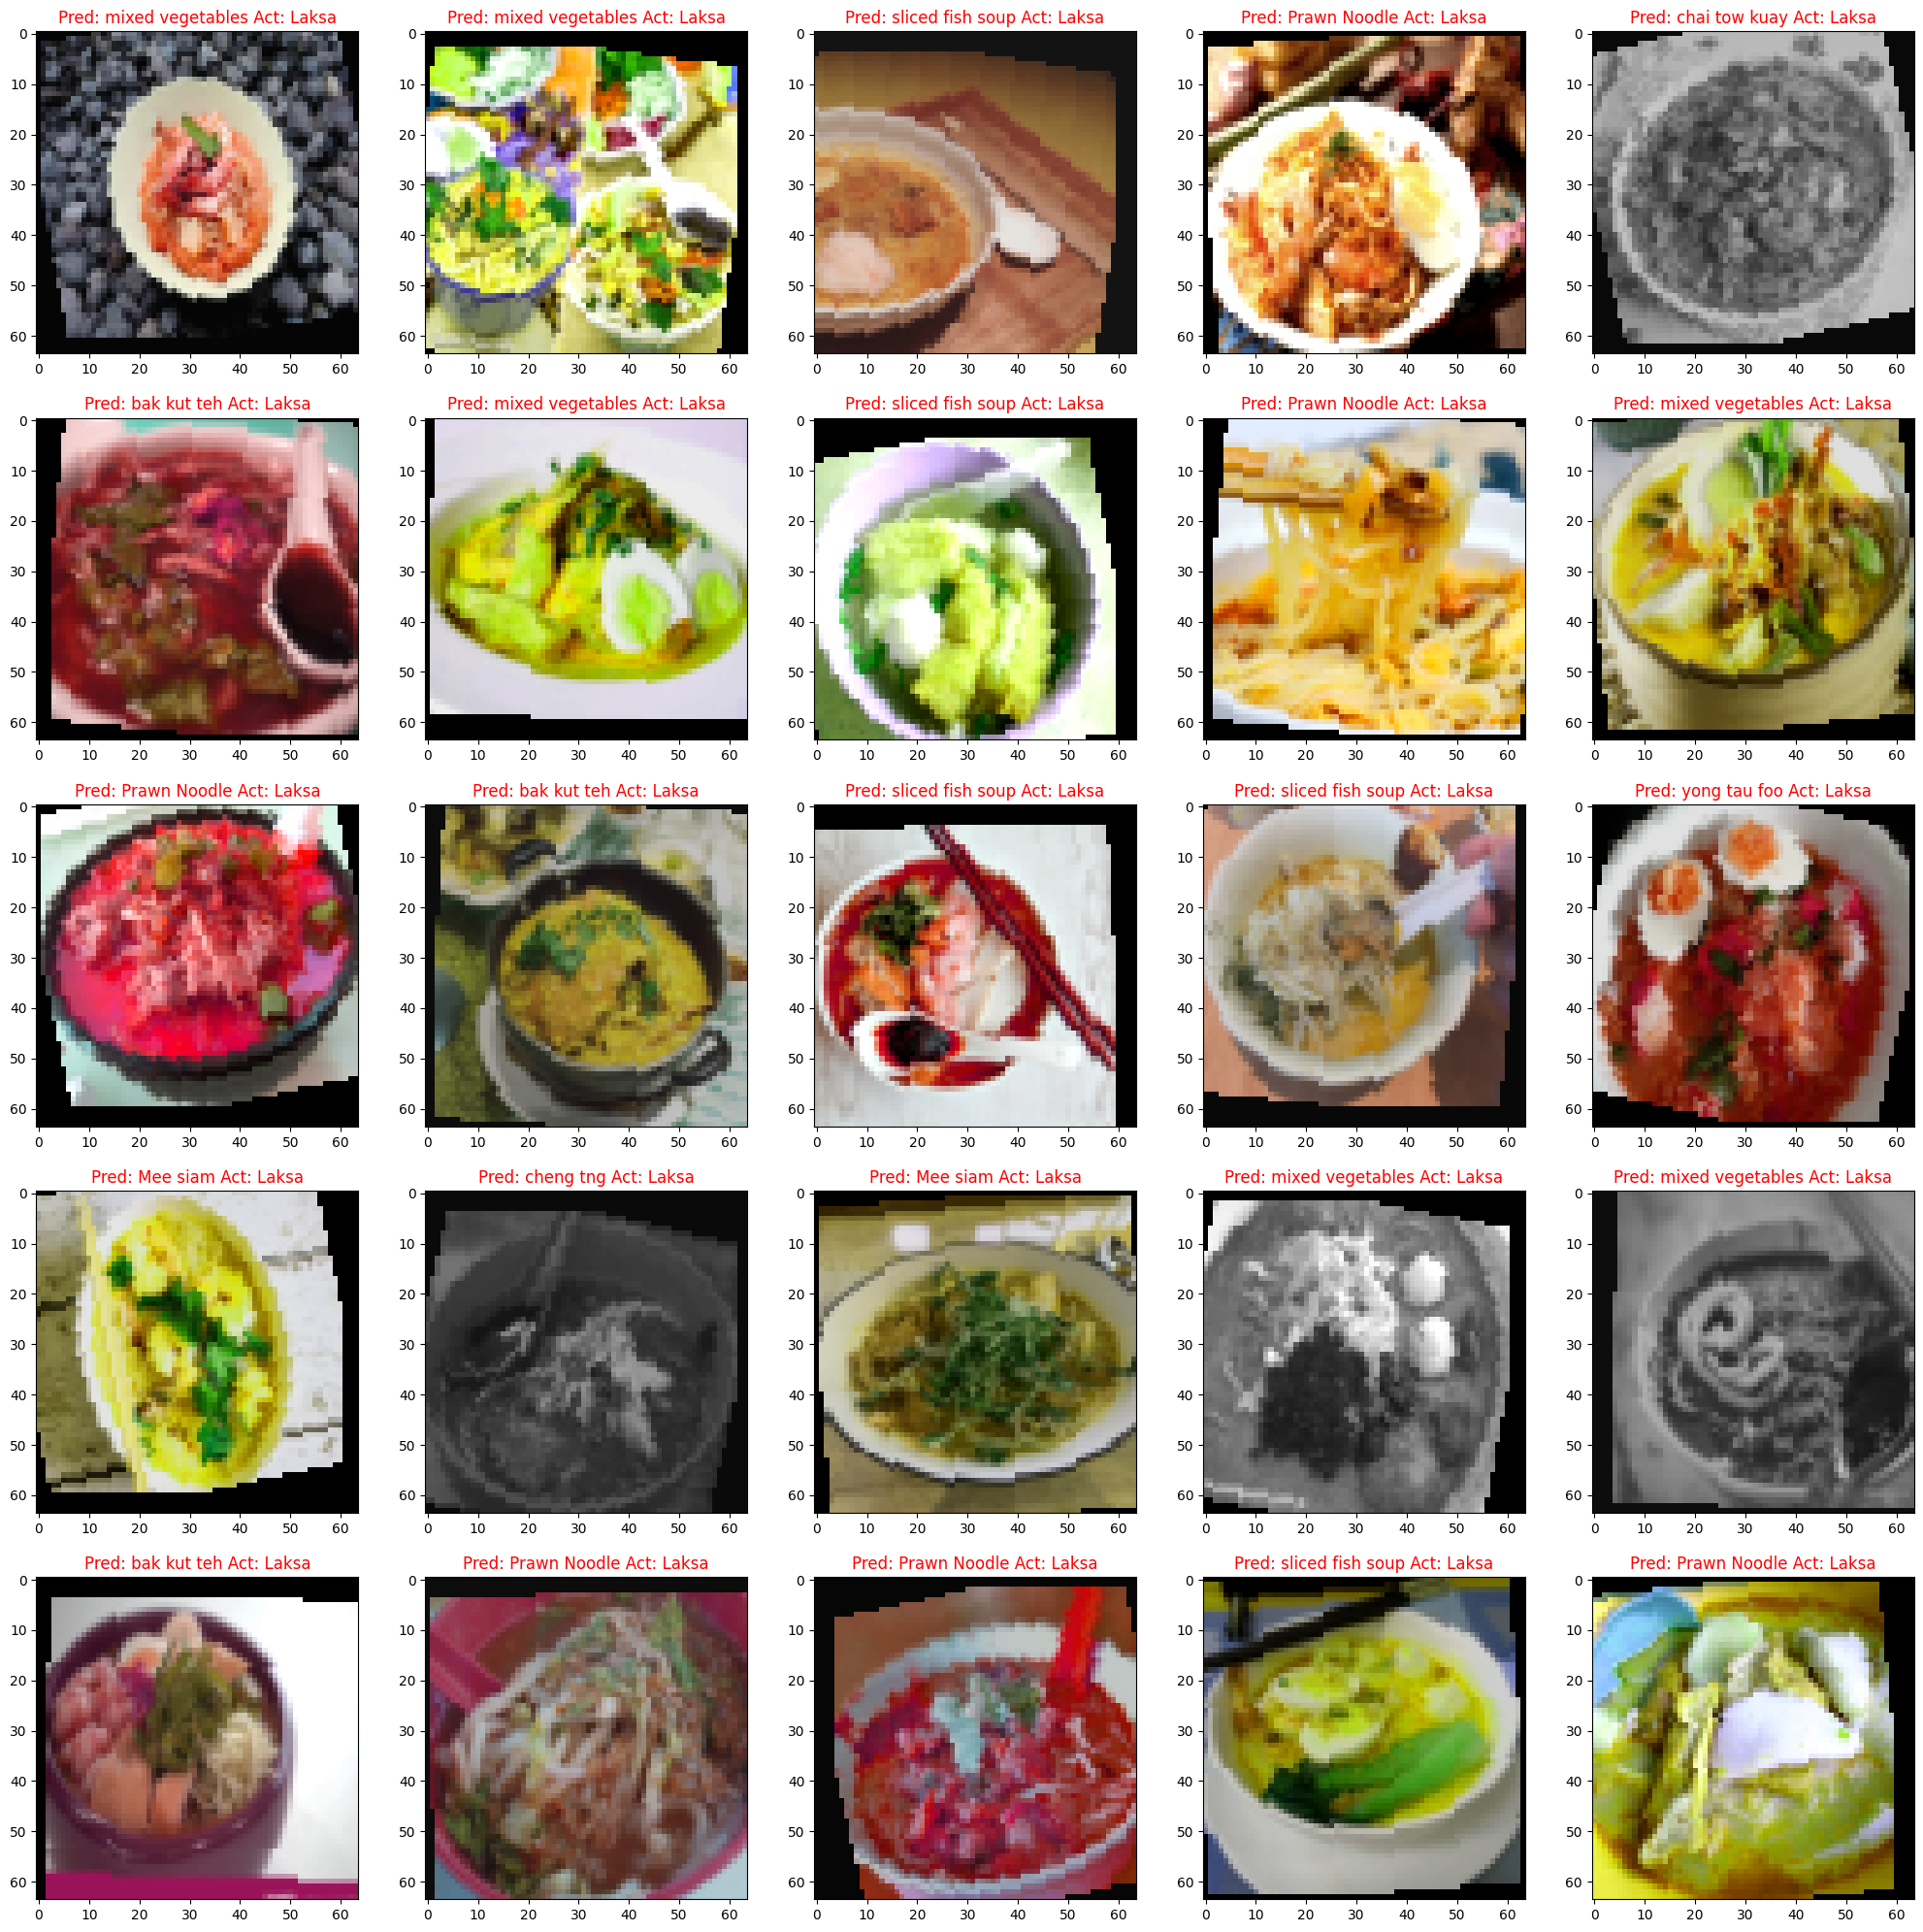

In [38]:
plot_data(model_0, test_dataloader, device, train_data.classes, plotRights=False)

In [39]:
def plot_conf_matrix(model, dataloader, device, classes):

  # Make predictions with the trained model
  y_preds = []
  y_true = []
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader, desc="Making Predictions..."):
      # Send the data and targets to target device
      X, y = X.to(device), y.to(device)
      # Do the forward pass
      y_logit = model(X)
      # Logits --> Prediction Probabilities --> Prediction Labels
      y_pred = y_logit.softmax(dim=1).argmax(dim=1)
      # Store Prediction labels
      y_preds.append(y_pred.cpu())
      # Store truth labels
      y_true.append(y.cpu())

  # Concatenate list of prediction labels into a tensor
  y_pred_tensor = torch.cat(y_preds)
  y_true_tensor = torch.cat(y_true)

  # Update the confusion matrix
  metric = confusion_matrix(y_true=y_true_tensor, y_pred=y_pred_tensor)

  figure, axis = mlxtend.plotting.plot_confusion_matrix(
    conf_mat=metric,
    class_names=classes
  )

Making Predictions...: 100%|██████████| 55/55 [00:13<00:00,  4.15it/s]


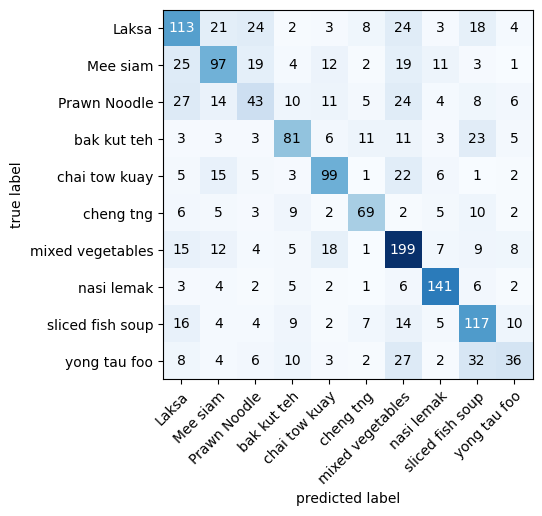

In [40]:
plot_conf_matrix(model_0, test_dataloader, device, test_data.classes)

In [41]:
torch.save(model_0.state_dict(), "12JanModelV2.pth")